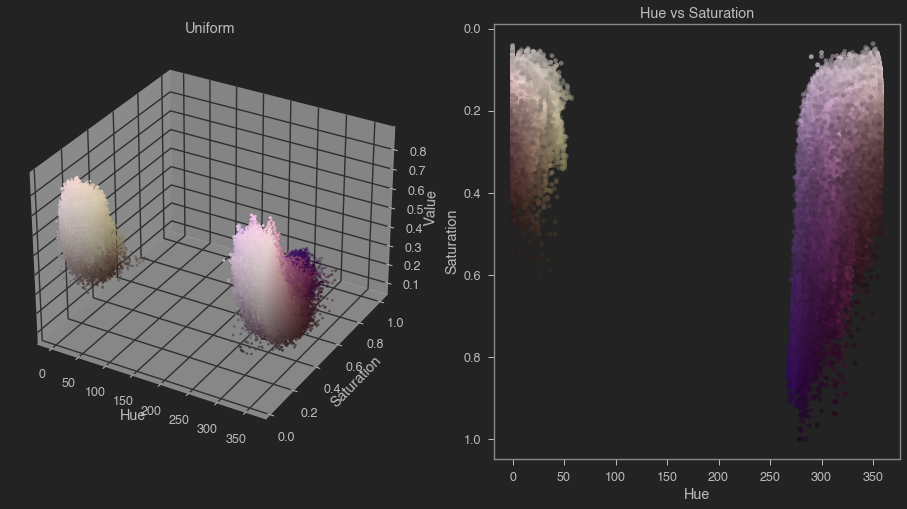

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple


img_path = 'img/img.png'
img = plt.imread(img_path)

# convert image to HSV color space
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# split the HSV channels
h, s, v = cv2.split(hsv_img)

# pixel colors
pixel_colors = img.reshape((np.shape(img)[0]*np.shape(img)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

# create the 3D scatter plot
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2)

# plot the image pixels in 3D
ax1.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".", s=20)
ax1.set_xlabel("Hue")
ax1.set_ylabel("Saturation")
ax1.set_zlabel("Value")
ax1.set_title("Uniform")

# plot the hue and saturation components
ax2.scatter(h.flatten(), s.flatten(), s=20, c=pixel_colors, alpha=0.5)
ax2.set_xlabel("Hue")
ax2.set_ylabel("Saturation")
ax2.set_title("Hue vs Saturation")
ax2.invert_yaxis()

# save the plot as PNG image
plt.savefig("scatterplot.png", dpi=300)

# show the plot
plt.show()

In [5]:
# convert image to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#H - 0:30, S - 0:150, V - 0:255
lower1 = np.array([0, 0, 0])  
upper1 = np.array([30, 150, 255])
mask1 = cv2.inRange(hsv, lower1, upper1) #первое облако точек

#H - 126:179, S - 0:50, V - 0:255
lower2 = np.array([126, 0, 0])
upper2 = np.array([179, 50, 255])
mask2 = cv2.inRange(hsv, lower2, upper2)#второе облако точек

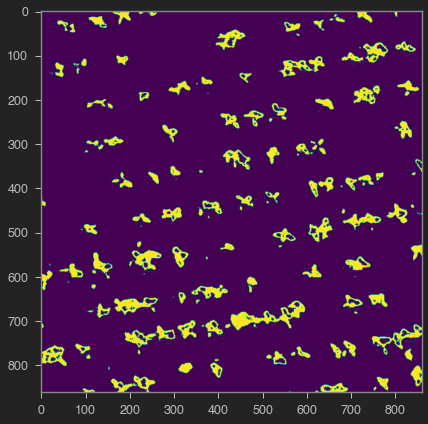

In [6]:
plt.imshow(mask1)

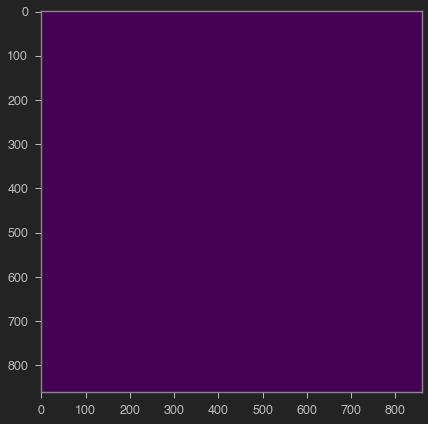

In [7]:
plt.imshow(mask2)

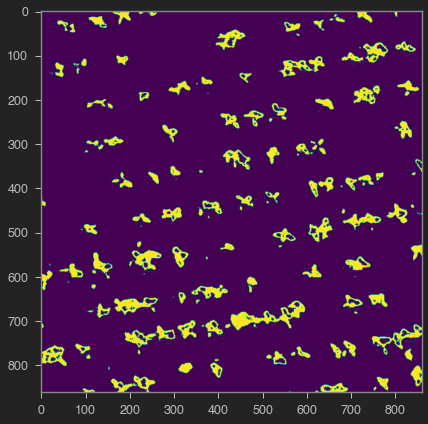

In [8]:
mask = mask1 + mask2
plt.imshow(mask)

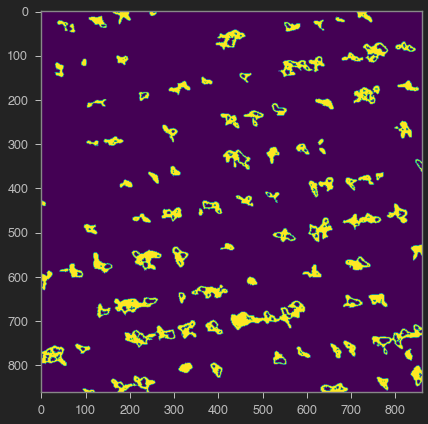

In [9]:
def find_objects(binary_map: np.ndarray) -> np.ndarray:
    """Remove small connected components from a binary image."""
    n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_map, 8, cv2.CV_32S)

    # get areas of all components except the background (first label)
    areas = stats[1:, cv2.CC_STAT_AREA]

    # сreate a new binary image with only the components whose area is >= 100
    result = np.zeros(labels.shape, np.uint8)
    for i, area in enumerate(areas):
        if area >= 100:
            result[labels == i+1] = 255

    return result

plt.imshow(find_objects(mask))

In [12]:
def get_contours(mask: np.ndarray) -> Tuple[List[np.ndarray], np.ndarray]:
    """Find contours with hierarchy."""
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours, hierarchy

def get_random_color() -> Tuple[float, float, float]:
    """Generate a random RGB color tuple."""
    return tuple(map(lambda x: x * 255, np.random.rand(3, )))

def draw_contours(mask: np.ndarray, contours: List[np.ndarray], hierarchy: np.ndarray) -> np.ndarray:
    """Draw all contours in an image, with different colors."""
    result_img = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    k = -1
    blobs = []
    for i, cnt in enumerate(contours):
        color = get_random_color()
        # hier[Next, Previous, First_Child, Parent]
        if hierarchy[0, i, 3] == -1:
            k += 1
        cv2.drawContours(result_img, [cnt], -1, color, 1)
        blobs.append(cnt)
    return result_img, blobs


clean_mask = find_objects(mask)
contours, hierarchy = get_contours(clean_mask)
result_img = draw_contours(clean_mask, contours, hierarchy)


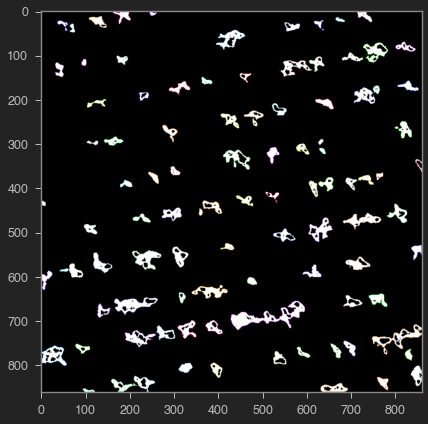

In [18]:
plt.imshow(result_img[0])

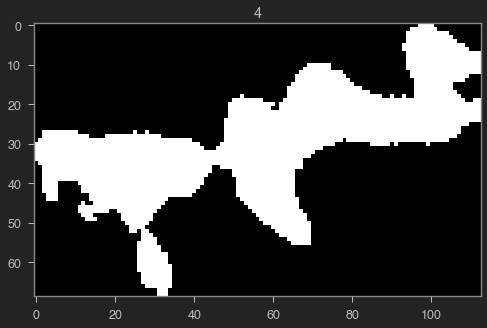

In [20]:
def get_median_contour_area(contours):
    areas = [cv2.contourArea(contour) for contour in contours]
    median_area = np.median(areas)
    return median_area

def get_cropped_images(contours, median_area, mask):
    cropped_images = []
    number_of_centers = []
    for contour in contours:
        # get contour area
        area = cv2.contourArea(contour)
        # calculate number of median areas in contour area
        if area > median_area*2:
            count_of_plants = int(area / median_area)
            number_of_centers.append(count_of_plants)

            # get minimum rotated bounding box
            box = cv2.minAreaRect(contour)
            # get the four corners of the bounding box
            box_points = cv2.boxPoints(box).astype(int)
            x, y, w, h = cv2.boundingRect(contour)
            crop = np.zeros((h, w, 3), dtype=np.uint8)

            # shift contour to be relative to crop
            shifted_contour = contour.copy()
            shifted_contour[:, :, 0] -= x
            shifted_contour[:, :, 1] -= y

            # draw contour on crop
            cv2.drawContours(crop, [shifted_contour], -1, (255, 255, 255), cv2.FILLED)

            cropped_images.append(crop)

    return cropped_images, number_of_centers

# find contours and minimum rotated bounding boxes
contours, hierarchy = get_contours(clean_mask)
median_area = get_median_contour_area(contours)
cropped_images, number_of_centers = get_cropped_images(contours, median_area, mask)

# plot result
plt.imshow(cropped_images[2])
plt.title(number_of_centers[2])
plt.show()

(113,)


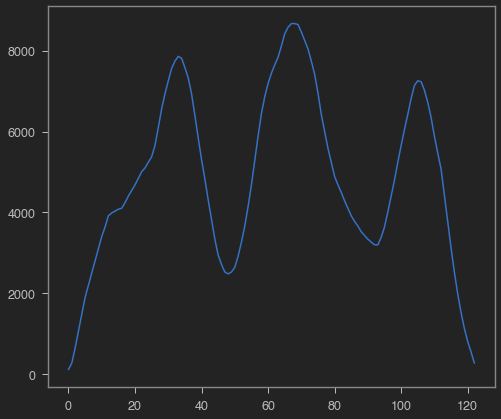

In [21]:
grey = cv2.cvtColor(cropped_images[2], cv2.COLOR_RGB2GRAY)
sum_vert = np.sum(grey,axis=0)
print(sum_vert.shape)
plt.plot(np.convolve(sum_vert,np.ones(11)/11))

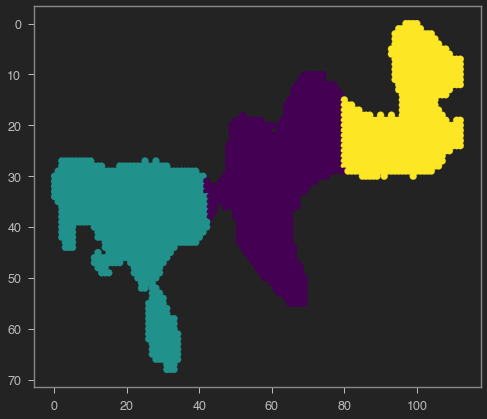

In [23]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=3, covariance_type='full')

model.fit(np.argwhere(grey == 255))
color = model.fit_predict(np.argwhere(grey == 255))
coord  = np.argwhere(grey == 255)
plt.scatter(coord[:, 1], coord[:, 0], c = color)
plt.gca().invert_yaxis()